# Speed Dating Data
https://www.kaggle.com/annavictoria/speed-dating-experiment

# 3 Feature Engineering/Pre-processing & Modeling (ver. keep chosen categorical columns), female decision


## 3.1  Imports

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from pandas_profiling import ProfileReport
from scipy import stats

from sb_utils import save_file

In [4]:
# not sure if I need this
import datetime
import unicodedata
import re
from sklearn.preprocessing import scale

## 3.2 Objectives

In the data wrangling notebook, we have identified our target dependent variable as desicion of parner of the specific subject, dec_o (might also consider match, desicion from both the subject and the partner) and cleaned the data accordingly. In this notebook, we will conduct further EDA, hoping to answer following questions.

1. The difference of desirable attributes in a male partner vs female partner.
2. The difference of desirable attributes among  races.
3. The difference of desirable major of male partner vs female partner
4. The difference of desirable majors among races.  

**Learning Objectives**:
Preprocessing:
1. Understand the importance of creating a model training development data set.
2. Correctly identify when to create dummy features or one-hot encoded features.
3. Understand the importance of magnitude standardization.
4. Apply the train and test split to the development dataset effectively

Modeling:
1. Fit your models with a training dataset 
    - Use cross-validation for hyperparameter tuning
2. Review model outcomes — Iterate over additional models as needed
    - Caclulate accuracy, recall, precision, and F1.
3. Identify the final model that you think is the best model for this project
    - Most power model interms of model evaluation metrics, computational complexity, scalability, and maintenance costs.

Here is possible workflow: TBD
1. Pre-processing:
    - Removed columns with categorical meaning before fillna with mean
    - Got dummy variables for all the columns with categorical meaning and with missing data
        - Converted the type int/float to object beforehand.
        - Make sure to use pd.get_dummies(df, drop_first=False), without dropping rows with missing values. Leave the first column so that missing value information is not lost.  Missing value can be considered as a category label as its own.
        - Removed the original categorical columns with missing data
    - Split into training/test set > fill NaN with mean, scale within training set and test set separately
        - Extract columns with numeric meaning to scale
        - Removed dummy variables columns and binary columns before scaling the numeric columns
        - Combined the dummy variable columns, binary columns and scaled numeric columns per train set and test set.
    - perform PCA on scaled numeric columns to reduce dimension
        - Keep enough pca components to explain ~90% var. 
        - Combined the dummy variable columns, binary columns and pca columns from scaled numeric columns
2. Modeling:
    - logistic regression model via sklearn and statsmodel
        - Use GridSearchCV (cv=5) for feature engineering
        - Use stepwise selection, elastic-net (or L1/L2 regularizers) if possible
    - Random Forest model via sklearn
    - Compare all models using confusion matrix and classification report
3. Feature importance analysis
    - Use SHAP for sklearn model
    - in order to answer feature importance for Male and Female, ran the model with male data and female data separately (done).
    - in ordr to answer feature importance for different races, can run the model with each race seprately (not done)

## 3.3 Load The Data

In [5]:
# df = pd.read_csv('../data/ski_data_cleaned.csv')
spd = pd.read_csv('spd_data_wrangling_output/Speed_Dating_data_cleaned.csv') #spd1_2 in data wrangling notebook
spd_fp = pd.read_csv('spd_data_wrangling_output/Speed_Dating_data_FemaleRatingMale_cleaned.csv') # spd1_2fp in data wrangling notebook 
#spd_mp = pd.read_csv('spd_data_wrangling_output/Speed_Dating_data_MaleRatingFemale_cleaned.csv') # spd1_2mp in data wrangling notebook

In [6]:
spd.head()

,gender,match,age,race,field,career,from,goal,int_corr,samerace,...,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o
0,0,0,21.0,4.0,Law,lawyer,Chicago,2.0,0.14,0,...,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0
1,0,0,21.0,4.0,Law,lawyer,Chicago,2.0,0.54,0,...,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0,2.0
2,0,1,21.0,4.0,Law,lawyer,Chicago,2.0,0.16,1,...,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0
3,0,1,21.0,4.0,Law,lawyer,Chicago,2.0,0.61,0,...,1,7.0,8.0,9.0,8.0,9.0,8.0,7.0,7.0,2.0
4,0,1,21.0,4.0,Law,lawyer,Chicago,2.0,0.21,0,...,1,8.0,7.0,9.0,6.0,9.0,7.0,8.0,6.0,2.0


In [7]:
spd = spd_fp

In [8]:
# gender = 1 = male subject = female pertner = female dec_o
spd.head()

,gender,match,age,race,field,career,from,goal,int_corr,samerace,...,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o
0,1,0,27.0,2.0,Finance,"Academia, Research, Banking, Life",Argentina,1.0,0.14,0,...,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0
1,1,0,27.0,2.0,Finance,"Academia, Research, Banking, Life",Argentina,1.0,0.29,1,...,0,5.0,7.0,8.0,4.0,6.0,3.0,6.0,4.0,2.0
2,1,0,27.0,2.0,Finance,"Academia, Research, Banking, Life",Argentina,1.0,-0.24,1,...,0,7.0,9.0,10.0,7.0,8.0,9.0,8.0,7.0,1.0
3,1,0,27.0,2.0,Finance,"Academia, Research, Banking, Life",Argentina,1.0,-0.18,1,...,0,4.0,10.0,8.0,5.0,8.0,7.0,6.0,7.0,2.0
4,1,0,27.0,2.0,Finance,"Academia, Research, Banking, Life",Argentina,1.0,-0.43,1,...,0,5.0,8.0,8.0,2.0,2.0,2.0,7.0,5.0,2.0


In [10]:
spd.gender.unique()

array([1], dtype=int64)

In [11]:
spd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3138 entries, 0 to 3137
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gender    3138 non-null   int64  
 1   match     3138 non-null   int64  
 2   age       3108 non-null   float64
 3   race      3118 non-null   float64
 4   field     3118 non-null   object 
 5   career    3118 non-null   object 
 6   from      3118 non-null   object 
 7   goal      3118 non-null   float64
 8   int_corr  3064 non-null   float64
 9   samerace  3138 non-null   int64  
 10  imprace   3118 non-null   float64
 11  imprelig  3118 non-null   float64
 12  age_o     3090 non-null   float64
 13  race_o    3090 non-null   float64
 14  dec_o     3138 non-null   int64  
 15  attr_o    3065 non-null   float64
 16  sinc_o    3039 non-null   float64
 17  intel_o   3033 non-null   float64
 18  fun_o     2995 non-null   float64
 19  amb_o     2852 non-null   float64
 20  shar_o    2671 non-null   floa

In [12]:
# check for NaN
spd.isna().sum() 
# need to remove cotegorical feature with type int or float before fill NaN with mean
# remove: race, goal, race_o, met_o > leave put to be dealt with dummy variables

gender        0
match         0
age          30
race         20
field        20
career       20
from         20
goal         20
int_corr     74
samerace      0
imprace      20
imprelig     20
age_o        48
race_o       48
dec_o         0
attr_o       73
sinc_o       99
intel_o     105
fun_o       143
amb_o       286
shar_o      467
like_o       96
prob_o      113
met_o       141
dtype: int64

In [13]:
# check for column value range
spd.describe()

,gender,match,age,race,goal,int_corr,samerace,imprace,imprelig,age_o,...,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o
count,3138.0,3138.000000,3108.000000,3118.000000,3118.000000,3064.000000,3138.000000,3118.000000,3118.000000,3090.000000,...,3138.000000,3065.000000,3039.000000,3033.000000,2995.000000,2852.000000,2671.000000,3042.000000,3025.000000,2997.000000
mean,1.0,0.170491,26.434041,2.672867,2.225786,0.192213,0.404398,3.459589,3.116421,26.079288,...,0.360421,5.976672,7.210102,7.535608,6.345409,7.056627,5.505990,6.062459,5.241818,1.956957
std,0.0,0.376123,3.403716,1.203183,1.492259,0.304037,0.490853,2.664324,2.586628,3.636065,...,0.480199,1.986416,1.814931,1.579798,2.045730,1.798915,2.203793,1.927802,2.155601,0.294275
min,1.0,0.000000,18.000000,1.000000,1.000000,-0.830000,0.000000,1.000000,1.000000,19.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.0,0.000000,24.000000,2.000000,1.000000,-0.020000,0.000000,1.000000,1.000000,23.000000,...,0.000000,5.000000,6.000000,7.000000,5.000000,6.000000,4.000000,5.000000,4.000000,2.000000
50%,1.0,0.000000,27.000000,2.000000,2.000000,0.210000,0.000000,3.000000,2.000000,26.000000,...,0.000000,6.000000,7.000000,8.000000,7.000000,7.000000,6.000000,6.000000,5.000000,2.000000
75%,1.0,0.000000,28.000000,4.000000,3.000000,0.430000,1.000000,6.000000,5.000000,28.000000,...,1.000000,7.000000,8.000000,9.000000,8.000000,8.000000,7.000000,7.000000,7.000000,2.000000
max,1.0,1.000000,42.000000,6.000000,6.000000,0.900000,1.000000,10.000000,10.000000,38.000000,...,1.000000,10.500000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,8.000000


In [14]:
# met_o supposed to be binary (1 or 2) column but it was not. double check its unique value
spd.met_o.unique() # people might have mistakenly input how many times have met before?

array([ 2.,  1., nan,  3.,  5.,  6.,  7.,  8.])

In [15]:
# check the value of categorical columns we want to get dummy variables
spd.race.unique()

array([ 2.,  4.,  3.,  1.,  6., nan])

In [16]:
spd.race_o.unique()

array([ 4.,  2.,  6.,  1.,  3., nan])

In [17]:
spd.field.unique() # too much but want to keep it for now

array(['Finance', 'Law', 'Business', 'political science', 'money',
       'Operations Research', 'law', 'Mechanical Engineering',
       'Economics', 'Psychology', 'Finanace', 'Finance&Economics',
       'Undergrad - GS', 'Mathematical Finance', 'Medicine', 'MBA', 'LAW',
       'Business & International Affairs', 'MFA Creative Writing',
       'Engineering', 'Electrical Engineering', 'Business (MBA)',
       'Computer Science', 'Climate-Earth and Environ. Science',
       'Social Work', 'financial math', 'Chemistry', 'Business- MBA',
       'chemistry', 'Religion', 'Film', 'Biomedical Engineering',
       'Economics and Political Science', 'Art History/medicine',
       'philosophy', 'physics (astrophysics)', 'Physics',
       'Business/ Finance/ Real Estate', 'Biochemistry', 'Art Education',
       'Philosophy', 'American Studies (Masters)', 'biology',
       'Cell Biology', 'Microbiology', 'math', 'International Business',
       'Statistics', 'Medical Informatics',
       'Internati

In [18]:
spd['from'].unique() # spd.from.unique() didn't work, too much options > drop b/c less interested

array(['Argentina', 'England', 'Southern California', 'Cincinnati, Ohio',
       'Miami', 'Milan - Italy', 'Georgia, USA', 'New York', 'california',
       'Washington DC', 'SF Bay Area, CA', 'China',
       'San Francisco(home)/Los Angeles(undergrad)', 'Spain', 'Israel',
       'Switzerland', 'Italy', 'Philadelphia', 'Houston', 'Brooklyn',
       'Boston', 'California', 'Mexico', 'Torrance, CA', 'St. Louis, MO',
       'London, UK', 'Boston, MA', 'Minnesota', 'Chicago', 'Bangladesh',
       'Long Island', 'Brooklyn, NY', 'India', 'Canada', 'Colorado',
       'Texas', 'Ann Arbor, MI', 'Hong Kong', 'Ann Arbor', 'Philippines',
       'Louisiana', 'Maryland', 'Staten Island', 'New York, NY',
       'Massachusetts', 'Connecticut', 'New Jersey', 'India, Holland',
       'NYC (Staten Island)', 'Greece', 'North Carolina',
       'State College, PA', 'Los Angeles', 'Detroit',
       'Washington DC Metro Region', 'colorado', 'Berkeley, CA',
       'Buffalo, NY', 'France', 'London, England', 'NJ

In [19]:
spd.career.unique() # too much options... this is 'intended' career > drop will keep filed instead 
# if want to include this, can reduce the option by merging similar ones.

array(['Academia, Research, Banking, Life', 'Corporate Lawyer', 'Lawyer',
       'Corporate attorney', 'research/financial industry',
       'academics or journalism', 'Financial Services', 'ceo', 'CEO',
       'tech professional', 'law', 'Engineer', 'Academic', 'academia',
       'banker / academia', 'banker', 'Music production', 'Entrepreneur',
       'lawyer', 'Law', 'Intellectual Property Attorney', 'Medicine',
       'consulting', 'LAWYER', 'Private Equity Investing',
       'Lawyer or professional surfer', 'novelist', 'Investment Banking',
       'Pro Beach Volleyball', 'Engineer or iBanker or consultant',
       'Trading', 'Ph.D. Electrical Engineering', 'attorney', 'Marketing',
       'Business - Investment Management', 'Academic or Research staff',
       'Professor', 'University Professor', 'Finance',
       'Research Scientist', 'business',
       'research in industry or academia', 'Teacher/Professor',
       'Engineering', 'film', 'Writer', 'Cardiologist', 'Law or finance'

In [20]:
spd.goal.unique() # goal for attending this speed dating, not many options so will keep

array([ 1.,  2.,  3.,  4.,  6.,  5., nan])

## 3.4 Pre-processing data

### 3.4.1 Get dummy variables of chosen categorical columns

In [21]:
# exctract categorical data
# refer to '14.5.6_Case Study - Gradient Boosting/Gradient Boosting Case Study_mk'
# dfo = df.select_dtypes(include='object')
# spd1 = spd[['race', 'field', 'career', 'from', 'goal', 'race_o', 'met_o']]  
#%%%%% converting all this features to variables took forever to run the ML model
spd1 = spd[['race', 'field', 'goal', 'race_o', 'met_o']]  # dropped less interested features
# did not include 'gender' and 'match' columns b/c they are binary column w/o missing data
spd1.head()

,race,field,goal,race_o,met_o
0,2.0,Finance,1.0,4.0,2.0
1,2.0,Finance,1.0,2.0,2.0
2,2.0,Finance,1.0,2.0,1.0
3,2.0,Finance,1.0,2.0,2.0
4,2.0,Finance,1.0,2.0,2.0


In [22]:
# check column type
spd1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3138 entries, 0 to 3137
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   race    3118 non-null   float64
 1   field   3118 non-null   object 
 2   goal    3118 non-null   float64
 3   race_o  3090 non-null   float64
 4   met_o   2997 non-null   float64
dtypes: float64(4), object(1)
memory usage: 122.7+ KB


In [23]:
# convert to object type 
spd1_o = spd1.astype('object') #%%%%% get_dummies did not work on int/float type
spd1_o.head()

,race,field,goal,race_o,met_o
0,2,Finance,1,4,2
1,2,Finance,1,2,2
2,2,Finance,1,2,1
3,2,Finance,1,2,2
4,2,Finance,1,2,2


In [24]:
# check column type
spd1_o.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3138 entries, 0 to 3137
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   race    3118 non-null   object
 1   field   3118 non-null   object
 2   goal    3118 non-null   object
 3   race_o  3090 non-null   object
 4   met_o   2997 non-null   object
dtypes: object(5)
memory usage: 122.7+ KB


In [25]:
# get dummy variable from the exctracted categorical data
# refer to 14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
spd1_odm = pd.get_dummies(spd1_o) # since spd1_o categorial type features still have many missing data, kept drop_first=False
spd1_odm.head() # pd.get_dummies() automatically removed the orignal categorical variables

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies (Masters),field_Architecture,field_Art Education,field_Art History/medicine,field_BUSINESS CONSULTING,...,race_o_3.0,race_o_4.0,race_o_6.0,met_o_1.0,met_o_2.0,met_o_3.0,met_o_5.0,met_o_6.0,met_o_7.0,met_o_8.0
0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [26]:
# check for NaN
spd1_odm.isna().sum()

race_1.0     0
race_2.0     0
race_3.0     0
race_4.0     0
race_6.0     0
            ..
met_o_3.0    0
met_o_5.0    0
met_o_6.0    0
met_o_7.0    0
met_o_8.0    0
Length: 118, dtype: int64

In [27]:
spd1_odm.shape

(3138, 118)

In [28]:
# extract the numeric data
spd2 = spd.drop(columns=['race', 'field', 'career', 'from', 'goal', 'race_o', 'met_o'])
spd2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3138 entries, 0 to 3137
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gender    3138 non-null   int64  
 1   match     3138 non-null   int64  
 2   age       3108 non-null   float64
 3   int_corr  3064 non-null   float64
 4   samerace  3138 non-null   int64  
 5   imprace   3118 non-null   float64
 6   imprelig  3118 non-null   float64
 7   age_o     3090 non-null   float64
 8   dec_o     3138 non-null   int64  
 9   attr_o    3065 non-null   float64
 10  sinc_o    3039 non-null   float64
 11  intel_o   3033 non-null   float64
 12  fun_o     2995 non-null   float64
 13  amb_o     2852 non-null   float64
 14  shar_o    2671 non-null   float64
 15  like_o    3042 non-null   float64
 16  prob_o    3025 non-null   float64
dtypes: float64(13), int64(4)
memory usage: 416.9 KB


In [29]:
# add these dummy variables back to the numeric data
# make sure to remove the original categorical data with missing data: field, career, from, 'race', 'goal', 'race_o', 'met_o'
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
spd_odm = pd.merge(spd1_odm, spd2, left_index=True, right_index=True)
print(spd_odm.shape)
spd_odm.head()

(3138, 135)


,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies (Masters),field_Architecture,field_Art Education,field_Art History/medicine,field_BUSINESS CONSULTING,...,age_o,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,0,1,0,0,0,0,0,0,0,0,...,21.0,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0
1,0,1,0,0,0,0,0,0,0,0,...,24.0,0,5.0,7.0,8.0,4.0,6.0,3.0,6.0,4.0
2,0,1,0,0,0,0,0,0,0,0,...,25.0,0,7.0,9.0,10.0,7.0,8.0,9.0,8.0,7.0
3,0,1,0,0,0,0,0,0,0,0,...,23.0,0,4.0,10.0,8.0,5.0,8.0,7.0,6.0,7.0
4,0,1,0,0,0,0,0,0,0,0,...,21.0,0,5.0,8.0,8.0,2.0,2.0,2.0,7.0,5.0


In [30]:
# check NaN
spd_odm.isna().sum() 

race_1.0      0
race_2.0      0
race_3.0      0
race_4.0      0
race_6.0      0
           ... 
fun_o       143
amb_o       286
shar_o      467
like_o       96
prob_o      113
Length: 135, dtype: int64

### 3.4.2 Set up/Split input data (X and y) into test set and train set

In [31]:
# spd_odm
X = spd_odm.drop(columns='dec_o')
y = spd_odm['dec_o']

In [32]:
# check
X.shape, y.shape

((3138, 134), (3138,))

In [33]:
X.head()

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies (Masters),field_Architecture,field_Art Education,field_Art History/medicine,field_BUSINESS CONSULTING,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,0,1,0,0,0,0,0,0,0,0,...,3.0,21.0,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0
1,0,1,0,0,0,0,0,0,0,0,...,3.0,24.0,5.0,7.0,8.0,4.0,6.0,3.0,6.0,4.0
2,0,1,0,0,0,0,0,0,0,0,...,3.0,25.0,7.0,9.0,10.0,7.0,8.0,9.0,8.0,7.0
3,0,1,0,0,0,0,0,0,0,0,...,3.0,23.0,4.0,10.0,8.0,5.0,8.0,7.0,6.0,7.0
4,0,1,0,0,0,0,0,0,0,0,...,3.0,21.0,5.0,8.0,8.0,2.0,2.0,2.0,7.0,5.0


In [34]:
y.head()

0    1
1    0
2    0
3    0
4    0
Name: dec_o, dtype: int64

In [35]:
# Split the data into a training and test set.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
X_train.head() # the index became random!

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies (Masters),field_Architecture,field_Art Education,field_Art History/medicine,field_BUSINESS CONSULTING,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
2784,0,1,0,0,0,0,0,0,0,0,...,4.0,24.0,8.0,7.0,6.0,6.0,5.0,5.0,7.0,5.0
1791,0,0,1,0,0,0,0,0,0,0,...,3.0,24.0,5.0,7.0,7.0,7.0,7.0,2.0,3.0,2.0
2825,0,0,0,1,0,0,0,0,0,0,...,1.0,26.0,7.0,6.0,7.0,8.0,8.0,6.0,6.0,5.0
1057,0,0,0,0,1,0,0,0,0,0,...,9.0,33.0,9.0,8.0,9.0,8.0,8.0,NaN,8.0,5.0
221,0,1,0,0,0,0,0,0,0,0,...,3.0,26.0,7.0,8.0,8.0,8.0,5.0,9.0,7.5,6.5


In [37]:
X_test.head() # the index became random!

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies (Masters),field_Architecture,field_Art Education,field_Art History/medicine,field_BUSINESS CONSULTING,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
1795,0,0,1,0,0,0,0,0,0,0,...,3.0,26.0,5.0,6.0,7.0,6.0,6.0,6.0,7.0,5.0
798,0,1,0,0,0,0,0,0,0,0,...,6.0,25.0,7.0,8.0,8.0,9.0,8.0,6.0,8.0,7.0
450,0,1,0,0,0,0,0,0,0,0,...,1.0,26.0,7.0,7.0,8.0,7.0,8.0,7.0,7.0,7.0
2564,0,0,0,1,0,0,0,0,0,1,...,6.0,33.0,5.0,9.0,8.0,5.0,7.0,NaN,7.0,7.0
2354,0,0,0,1,0,0,0,0,0,0,...,1.0,26.0,6.0,5.0,5.0,6.0,6.0,3.0,3.0,6.0


In [38]:
# reset index
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html
X_train = X_train.reset_index(drop=True)
X_train.head()

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies (Masters),field_Architecture,field_Art Education,field_Art History/medicine,field_BUSINESS CONSULTING,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,0,1,0,0,0,0,0,0,0,0,...,4.0,24.0,8.0,7.0,6.0,6.0,5.0,5.0,7.0,5.0
1,0,0,1,0,0,0,0,0,0,0,...,3.0,24.0,5.0,7.0,7.0,7.0,7.0,2.0,3.0,2.0
2,0,0,0,1,0,0,0,0,0,0,...,1.0,26.0,7.0,6.0,7.0,8.0,8.0,6.0,6.0,5.0
3,0,0,0,0,1,0,0,0,0,0,...,9.0,33.0,9.0,8.0,9.0,8.0,8.0,NaN,8.0,5.0
4,0,1,0,0,0,0,0,0,0,0,...,3.0,26.0,7.0,8.0,8.0,8.0,5.0,9.0,7.5,6.5


In [39]:
X_test = X_test.reset_index(drop=True)
X_test.head()

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies (Masters),field_Architecture,field_Art Education,field_Art History/medicine,field_BUSINESS CONSULTING,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,0,0,1,0,0,0,0,0,0,0,...,3.0,26.0,5.0,6.0,7.0,6.0,6.0,6.0,7.0,5.0
1,0,1,0,0,0,0,0,0,0,0,...,6.0,25.0,7.0,8.0,8.0,9.0,8.0,6.0,8.0,7.0
2,0,1,0,0,0,0,0,0,0,0,...,1.0,26.0,7.0,7.0,8.0,7.0,8.0,7.0,7.0,7.0
3,0,0,0,1,0,0,0,0,0,1,...,6.0,33.0,5.0,9.0,8.0,5.0,7.0,NaN,7.0,7.0
4,0,0,0,1,0,0,0,0,0,0,...,1.0,26.0,6.0,5.0,5.0,6.0,6.0,3.0,3.0,6.0


In [40]:
#%%%% should rest_index for statsmodel input to avoid 'ValueError: The indices for endog and exog are not aligned'
#%%%% make sure to 'drop=True' to keep y as 1d array (2d array etc will cause error as input for sklearn).
y_train = y_train.reset_index(drop=True) 
y_test = y_test.reset_index(drop=True)
y_train.shape, y_test.shape

((2510,), (628,))

In [41]:
y_train

0       0
1       0
2       0
3       1
4       1
       ..
2505    0
2506    0
2507    0
2508    0
2509    0
Name: dec_o, Length: 2510, dtype: int64

### 3.4.3 Filling NaN of numeric data with mean

In [42]:
y.isna().sum() # no need to clean 

0

In [43]:
# extract categorial data & binary data without missing data
X_train1 = X_train.loc[:, 'race_1.0':'match']
X_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2510 entries, 0 to 2509
Columns: 120 entries, race_1.0 to match
dtypes: int64(2), uint8(118)
memory usage: 328.6 KB


In [44]:
X_test1 = X_test.loc[:, 'race_1.0':'match']
X_test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Columns: 120 entries, race_1.0 to match
dtypes: int64(2), uint8(118)
memory usage: 82.3 KB


In [45]:
# check for NaN
X_train1.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [46]:
X_test1.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [47]:
# extract the numeric data with missing data
X_train2 = X_train.loc[:, 'age':'prob_o'] # samerace is binary feature without missing data
X_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2510 entries, 0 to 2509
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2485 non-null   float64
 1   int_corr  2453 non-null   float64
 2   samerace  2510 non-null   int64  
 3   imprace   2493 non-null   float64
 4   imprelig  2493 non-null   float64
 5   age_o     2476 non-null   float64
 6   attr_o    2447 non-null   float64
 7   sinc_o    2426 non-null   float64
 8   intel_o   2423 non-null   float64
 9   fun_o     2389 non-null   float64
 10  amb_o     2276 non-null   float64
 11  shar_o    2124 non-null   float64
 12  like_o    2429 non-null   float64
 13  prob_o    2417 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 274.7 KB


In [48]:
X_test2 = X_test.loc[:, 'age':'prob_o'] # samerace is binary feature without missing data
X_test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       623 non-null    float64
 1   int_corr  611 non-null    float64
 2   samerace  628 non-null    int64  
 3   imprace   625 non-null    float64
 4   imprelig  625 non-null    float64
 5   age_o     614 non-null    float64
 6   attr_o    618 non-null    float64
 7   sinc_o    613 non-null    float64
 8   intel_o   610 non-null    float64
 9   fun_o     606 non-null    float64
 10  amb_o     576 non-null    float64
 11  shar_o    547 non-null    float64
 12  like_o    613 non-null    float64
 13  prob_o    608 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 68.8 KB


In [49]:
# fill mean within train set
X_train2_mean = X_train2.fillna(X_train2.mean())
# check for NaN
X_train2_mean.isna().sum(), X_train2_mean.shape

(age         0
 int_corr    0
 samerace    0
 imprace     0
 imprelig    0
 age_o       0
 attr_o      0
 sinc_o      0
 intel_o     0
 fun_o       0
 amb_o       0
 shar_o      0
 like_o      0
 prob_o      0
 dtype: int64,
 (2510, 14))

In [50]:
# fill mean within test set
X_test2_mean = X_test2.fillna(X_test2.mean())
# check for NaN
X_test2_mean.isna().sum(), X_test2_mean.shape

(age         0
 int_corr    0
 samerace    0
 imprace     0
 imprelig    0
 age_o       0
 attr_o      0
 sinc_o      0
 intel_o     0
 fun_o       0
 amb_o       0
 shar_o      0
 like_o      0
 prob_o      0
 dtype: int64,
 (628, 14))

### 3.4.4 Scale continuous numeric features (leaving out the target, binary, and categorical features)

In [51]:
# check range
X_train2_mean.describe()

,age,int_corr,samerace,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
count,2510.000000,2510.000000,2510.000000,2510.000000,2510.000000,2510.000000,2510.000000,2510.000000,2510.000000,2510.000000,2510.000000,2510.000000,2510.000000,2510.000000
mean,26.442656,0.195455,0.403586,3.437224,3.113518,26.119548,5.977115,7.219909,7.559018,6.338008,7.065246,5.511064,6.055578,5.227348
std,3.373819,0.297618,0.490714,2.642618,2.575514,3.659948,1.987127,1.797315,1.571221,2.023902,1.743011,2.051790,1.929455,2.122290
min,18.000000,-0.700000,0.000000,1.000000,1.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,-0.010000,0.000000,1.000000,1.000000,23.000000,5.000000,6.000000,7.000000,5.000000,6.000000,4.000000,5.000000,4.000000
50%,27.000000,0.200000,0.000000,3.000000,2.000000,26.000000,6.000000,7.000000,8.000000,6.338008,7.000000,5.511064,6.000000,5.000000
75%,28.000000,0.420000,1.000000,6.000000,5.000000,28.000000,7.000000,8.000000,9.000000,8.000000,8.000000,7.000000,7.000000,7.000000
max,42.000000,0.900000,1.000000,10.000000,10.000000,38.000000,10.500000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [52]:
X_test2_mean.describe()

,age,int_corr,samerace,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
count,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000
mean,26.399679,0.179198,0.407643,3.548800,3.128000,25.916938,5.974919,7.171289,7.442623,6.374587,7.022569,5.486289,6.089723,5.299342
std,3.443664,0.311325,0.491788,2.708237,2.591779,3.391227,1.865861,1.741241,1.476283,1.895167,1.598797,1.958357,1.768304,2.093515
min,18.000000,-0.830000,0.000000,1.000000,1.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,-0.020000,0.000000,1.000000,1.000000,23.000000,5.000000,6.000000,7.000000,5.000000,6.000000,5.000000,5.000000,4.000000
50%,27.000000,0.190000,0.000000,3.000000,2.000000,25.916938,6.000000,7.000000,7.442623,7.000000,7.000000,5.486289,6.000000,5.000000
75%,28.000000,0.410000,1.000000,6.000000,5.000000,28.000000,7.000000,8.000000,8.000000,8.000000,8.000000,7.000000,7.000000,7.000000
max,42.000000,0.900000,1.000000,10.000000,10.000000,38.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [53]:
# drop samerace, binary feature without missing data
X_train3_mean = X_train2_mean.drop(columns='samerace')
X_test3_mean = X_test2_mean.drop(columns='samerace')

In [54]:
# refer to '6_GuidedCapstone/04_preprocessing_and_training_mk'
# refer to '16.3.1_Capstone_Two_Step_4__Preprocessing_Training_Data_Development.pdf'
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk.ipynb'
from sklearn.preprocessing import StandardScaler
# Making a Scaler object based on train set and apply it to test set to scale the test set
scaler = StandardScaler().fit(X_train3_mean)

# apply the scaler to train set
X_train_mean_scaled = scaler.transform(X_train3_mean)
print(type(X_train_mean_scaled))
X_train_mean_scaled = pd.DataFrame(X_train_mean_scaled, columns=X_train3_mean.columns)
X_train_mean_scaled.head()

<class 'numpy.ndarray'>


,age,int_corr,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,-1.020607,1.497031e-01,-0.922460,0.344265,-0.579235,1.018198,-0.122379,-0.992431,-0.167041,-1.185109,-0.249132,0.489573,-0.107145
1,-0.724148,8.890529e-01,-0.165484,-0.044085,-0.579235,-0.491820,-0.122379,-0.355856,0.327152,-0.037440,-1.711561,-1.583964,-1.520994
2,0.165230,3.513439e-01,-0.922460,-0.820783,-0.032670,0.514858,-0.678875,-0.355856,0.821346,0.536394,0.238345,-0.028811,-0.107145
3,-0.131229,8.248944e-02,-0.922460,2.286012,1.880306,1.521537,0.434118,0.917292,0.821346,0.536394,0.000000,1.007958,-0.107145
4,-0.131229,6.529435e-16,-0.543972,-0.044085,-0.032670,0.514858,0.434118,0.280718,0.821346,-1.185109,1.700774,0.748766,0.599779


In [55]:
# apply the scaler to test set
X_test_mean_scaled = scaler.transform(X_test3_mean)
print(type(X_test_mean_scaled))
X_test_mean_scaled = pd.DataFrame(X_test_mean_scaled, columns=X_test3_mean.columns)
X_test_mean_scaled.head()

<class 'numpy.ndarray'>


,age,int_corr,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,-0.724148,0.653805,-0.165484,-0.044085,-0.032670,-0.491820,-0.678875,-0.355856,-0.167041,-0.611275,0.238345,0.489573,-0.107145
1,0.461689,1.897257,0.213004,1.120964,-0.305953,0.514858,0.434118,0.280718,1.315540,0.536394,0.238345,1.007958,0.835421
2,-0.131229,0.586592,0.591492,-0.820783,-0.032670,0.514858,-0.122379,0.280718,0.327152,0.536394,0.725821,0.489573,0.835421
3,1.054607,-0.287185,0.969980,1.120964,1.880306,-0.491820,0.990614,0.280718,-0.661235,-0.037440,-0.012077,0.489573,0.835421
4,-1.020607,-0.018331,-0.922460,-0.820783,-0.032670,0.011519,-1.235371,-1.629005,-0.167041,-0.611275,-1.224085,-1.583964,0.364138


In [56]:
# check size
X_train_mean_scaled.shape, X_test_mean_scaled.shape

((2510, 13), (628, 13))

In [57]:
# Combine scaled features + dummy variabls + the original binary features
# X_train_mean_scaled + X_train1 + X_train2_mean['samerace']
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
#%%%% if using left_index and right_index to merge df, need to make sure the index are reset starting from 0.
X_train_odmb = pd.merge(X_train1, X_train2_mean['samerace'], left_index=True, right_index=True) 
print(X_train_odmb.shape)
X_train_mean_scaled_odmb = pd.merge(X_train_mean_scaled, X_train_odmb, left_index=True, right_index=True)
print(X_train_mean_scaled_odmb.shape)
X_train_mean_scaled_odmb.head() 

(2510, 121)
(2510, 134)


,age,int_corr,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,...,met_o_1.0,met_o_2.0,met_o_3.0,met_o_5.0,met_o_6.0,met_o_7.0,met_o_8.0,gender,match,samerace
0,-1.020607,1.497031e-01,-0.922460,0.344265,-0.579235,1.018198,-0.122379,-0.992431,-0.167041,-1.185109,...,0,1,0,0,0,0,0,1,0,1
1,-0.724148,8.890529e-01,-0.165484,-0.044085,-0.579235,-0.491820,-0.122379,-0.355856,0.327152,-0.037440,...,0,1,0,0,0,0,0,1,0,0
2,0.165230,3.513439e-01,-0.922460,-0.820783,-0.032670,0.514858,-0.678875,-0.355856,0.821346,0.536394,...,0,1,0,0,0,0,0,1,0,0
3,-0.131229,8.248944e-02,-0.922460,2.286012,1.880306,1.521537,0.434118,0.917292,0.821346,0.536394,...,0,1,0,0,0,0,0,1,0,0
4,-0.131229,6.529435e-16,-0.543972,-0.044085,-0.032670,0.514858,0.434118,0.280718,0.821346,-1.185109,...,0,1,0,0,0,0,0,1,1,1


In [58]:
# X_test_mean_scaled + X_test1 + X_test2_mean['samerace']
#%%%% if using left_index and right_index to merge df, need to make sure the index are reset starting from 0.
X_test_odmb = pd.merge(X_test1, X_test2_mean['samerace'], left_index=True, right_index=True)
print(X_test_odmb.shape)
#X_train_odmb.head()
X_test_mean_scaled_odmb = pd.merge(X_test_mean_scaled, X_test_odmb, left_index=True, right_index=True)
print(X_test_mean_scaled_odmb.shape)
X_test_mean_scaled_odmb.head() #%%%%%% why the row number discreased??

(628, 121)
(628, 134)


,age,int_corr,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,...,met_o_1.0,met_o_2.0,met_o_3.0,met_o_5.0,met_o_6.0,met_o_7.0,met_o_8.0,gender,match,samerace
0,-0.724148,0.653805,-0.165484,-0.044085,-0.032670,-0.491820,-0.678875,-0.355856,-0.167041,-0.611275,...,0,1,0,0,0,0,0,1,0,0
1,0.461689,1.897257,0.213004,1.120964,-0.305953,0.514858,0.434118,0.280718,1.315540,0.536394,...,0,1,0,0,0,0,0,1,0,0
2,-0.131229,0.586592,0.591492,-0.820783,-0.032670,0.514858,-0.122379,0.280718,0.327152,0.536394,...,0,1,0,0,0,0,0,1,0,0
3,1.054607,-0.287185,0.969980,1.120964,1.880306,-0.491820,0.990614,0.280718,-0.661235,-0.037440,...,0,1,0,0,0,0,0,1,0,0
4,-1.020607,-0.018331,-0.922460,-0.820783,-0.032670,0.011519,-1.235371,-1.629005,-0.167041,-0.611275,...,0,1,0,0,0,0,0,1,0,0


### 3.4.5 Use PCA for demension reduction of numeric features

In [59]:
# check size of numeric features 
X_train_mean_scaled.shape, X_test_mean_scaled.shape

((2510, 13), (628, 13))

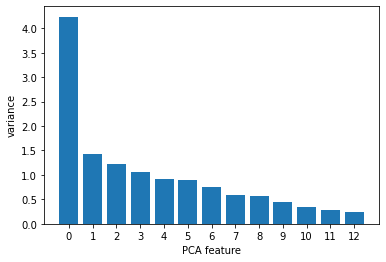

In [60]:
# refer to '15.4.3_3_Unsupervised Learning_Dimension reduction'
# Create a PCA instance: pca
pca = PCA()

# Fit model to numeric features
pca.fit(X_train_mean_scaled)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

It looks like PCA features 0 have the most significant variance (first elbow). Will keep PCA features 0 - 3 (2nd elbow) for more variance to be conservative.

In [61]:
# Create a PCA model with 4 components: pca
pca = PCA(n_components=4)

# Fit the PCA instance to the numeric features
pca.fit(X_train_mean_scaled)

# Transform the numeric features: pca_features
pca_X_train_mean_scaled = pca.transform(X_train_mean_scaled)

# Print the shape of pca_features
print(pca_X_train_mean_scaled.shape)
print(type(pca_X_train_mean_scaled))
pca_X_train_mean_scaled = pd.DataFrame(pca_X_train_mean_scaled, columns=['pca0','pca1','pca2','pca3'])
pca_X_train_mean_scaled.head()

(2510, 4)
<class 'numpy.ndarray'>


,pca0,pca1,pca2,pca3
0,0.383936,-0.557947,-1.122811,-1.066820
1,1.862203,-0.155697,-0.171246,1.303429
2,-0.390306,-1.309707,0.103138,-0.366530
3,-1.835746,0.977366,1.292009,-0.798517
4,-1.459260,-0.534041,-0.320691,-1.306577


In [62]:
# Create a PCA model with 4 components: pca
pca = PCA(n_components=4)

# Fit the PCA instance to the numeric features
pca.fit(X_test_mean_scaled)

# Transform the numeric features: pca_features
pca_X_test_mean_scaled = pca.transform(X_test_mean_scaled)

# Print the shape of pca_features
print(pca_X_test_mean_scaled.shape)
print(type(pca_X_test_mean_scaled))
pca_X_test_mean_scaled = pd.DataFrame(pca_X_test_mean_scaled, columns=['pca0','pca1','pca2','pca3'])
pca_X_test_mean_scaled.head()

(628, 4)
<class 'numpy.ndarray'>


,pca0,pca1,pca2,pca3
0,0.478911,-0.314817,0.218213,-0.994320
1,-1.849760,0.570959,1.669514,-0.739254
2,-1.308335,-0.180429,0.496730,-0.174642
3,-0.443287,1.202335,1.424713,1.007947
4,2.142432,-1.368078,-0.743724,-0.682896


In [63]:
# Combine pca scaled features + dummy variabls + the original binary features
# pca_X_train_mean_scaled + X_train1 + X_train2_mean['samerace']
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
#%%%% if using left_index and right_index to merge df, need to make sure the index are reset starting from 0.
# X_train_odmb = pd.merge(X_train1, X_train2_mean['samerace'], left_index=True, right_index=True) 
# print(X_train_odmb.shape)
pca_X_train_mean_scaled_odmb = pd.merge(pca_X_train_mean_scaled, X_train_odmb, left_index=True, right_index=True)
print(pca_X_train_mean_scaled_odmb.shape)
pca_X_train_mean_scaled_odmb.head() 

(2510, 125)


,pca0,pca1,pca2,pca3,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies (Masters),...,met_o_1.0,met_o_2.0,met_o_3.0,met_o_5.0,met_o_6.0,met_o_7.0,met_o_8.0,gender,match,samerace
0,0.383936,-0.557947,-1.122811,-1.066820,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
1,1.862203,-0.155697,-0.171246,1.303429,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,-0.390306,-1.309707,0.103138,-0.366530,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
3,-1.835746,0.977366,1.292009,-0.798517,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
4,-1.459260,-0.534041,-0.320691,-1.306577,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,1,1


In [64]:
# pca_X_test_mean_scaled + X_test1 + X_test2_mean['samerace']
#%%%% if using left_index and right_index to merge df, need to make sure the index are reset starting from 0.
# X_test_odmb = pd.merge(X_test1, X_test2_mean['samerace'], left_index=True, right_index=True)
# print(X_test_odmb.shape)
# X_train_odmb.head()
pca_X_test_mean_scaled_odmb = pd.merge(pca_X_test_mean_scaled, X_test_odmb, left_index=True, right_index=True)
print(pca_X_test_mean_scaled_odmb.shape)
pca_X_test_mean_scaled_odmb.head() 

(628, 125)


,pca0,pca1,pca2,pca3,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies (Masters),...,met_o_1.0,met_o_2.0,met_o_3.0,met_o_5.0,met_o_6.0,met_o_7.0,met_o_8.0,gender,match,samerace
0,0.478911,-0.314817,0.218213,-0.994320,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,-1.849760,0.570959,1.669514,-0.739254,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,-1.308335,-0.180429,0.496730,-0.174642,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,-0.443287,1.202335,1.424713,1.007947,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
4,2.142432,-1.368078,-0.743724,-0.682896,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0


## 3.5 Fit Model 

### 3.5.1 LogisticRegression via sklearn

In [65]:
# make sure the y input for sklearn model is 1d array
y_train.shape, y_test.shape

((2510,), (628,))

In [66]:
np.logspace(-5, 8, 15)

array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08])

#### 3.5.1.1 numeric features without PCA

In [74]:
%%time
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'

# logistic regresion w elastic penalty
# refer to '14.1.2_3_Supervised Learning_Tuning'
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 2)
l1_space = np.arange(0,1,0.5)
param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 


# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1) 
#%%%%%% need to specify solver and max_inter (default setting does not work)
#%%%%% n_jobs=-1 to make the code run faster by running codes parallelly!?

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)

# Fit it to the data
logreg_cv.fit(X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
logreg_best0 = logreg_cv.best_estimator_
training_accuracy = logreg_best0.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = logreg_best0.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Predict the labels of the test data: y_pred
y_pred0 = logreg_best0.predict(X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred0))
print(classification_report(y_test, y_pred0))

Tuned Logistic Regression Parameters: {'C': 100000000.0, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
Best score is 0.847011952191235
Accuracy on training data: 0.87
Accuracy on test data:     0.86
[[384  32]
 [ 58 154]]
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       416
           1       0.83      0.73      0.77       212

    accuracy                           0.86       628
   macro avg       0.85      0.82      0.83       628
weighted avg       0.85      0.86      0.85       628

Wall time: 26.8 s


In [68]:
%%time
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'

# logistic regresion w elastic penalty
# refer to '14.1.2_3_Supervised Learning_Tuning'
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
l1_space = np.arange(0,1,0.1)
param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 


# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1)
#%%%%%% need to specify solver and max_inter (default setting does not work)
#%%%%% n_jobs=-1 to make the code run faster by running codes parallelly!?

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)

# Fit it to the data
logreg_cv.fit(X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
logreg_best1 = logreg_cv.best_estimator_
training_accuracy = logreg_best1.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = logreg_best1.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Predict the labels of the test data: y_pred
y_pred1 = logreg_best1.predict(X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred1))
print(classification_report(y_test, y_pred1))

Tuned Logistic Regression Parameters: {'C': 0.4393970560760795, 'l1_ratio': 0.4, 'penalty': 'elasticnet'}
Best score is 0.8541832669322709
Accuracy on training data: 0.86
Accuracy on test data:     0.86
[[393  23]
 [ 67 145]]
              precision    recall  f1-score   support

           0       0.85      0.94      0.90       416
           1       0.86      0.68      0.76       212

    accuracy                           0.86       628
   macro avg       0.86      0.81      0.83       628
weighted avg       0.86      0.86      0.85       628

Wall time: 13min 1s


#### 3.5.1.2 numeric features with PCA

In [69]:
%%time
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'

# logistic regresion w elastic penalty
# refer to '14.1.2_3_Supervised Learning_Tuning'
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 2)
l1_space = np.arange(0,1,0.5)
param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1) 
#%%%%%% need to specify solver and max_inter (default setting does not work)
#%%%%% n_jobs=-1 to make the code run faster by running codes parallelly!?

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)

# Fit it to the data
logreg_cv.fit(pca_X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
logreg_best2 = logreg_cv.best_estimator_
training_accuracy = logreg_best2.score(pca_X_train_mean_scaled_odmb, y_train)
test_accuracy = logreg_best2.score(pca_X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Predict the labels of the test data: y_pred
y_pred2 = logreg_best2.predict(pca_X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Tuned Logistic Regression Parameters: {'C': 100000000.0, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
Best score is 0.847808764940239
Accuracy on training data: 0.87
Accuracy on test data:     0.83
[[374  42]
 [ 65 147]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       416
           1       0.78      0.69      0.73       212

    accuracy                           0.83       628
   macro avg       0.81      0.80      0.80       628
weighted avg       0.83      0.83      0.83       628

Wall time: 24.5 s


In [70]:
%%time
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'

# logistic regresion w elastic penalty
# refer to '14.1.2_3_Supervised Learning_Tuning'
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
l1_space = np.arange(0,1,0.1)
param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 


# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1) 
#%%%%%% need to specify solver and max_inter (default setting does not work)
#%%%%% n_jobs=-1 to make the code run faster by running codes parallelly!?

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)

# Fit it to the data
logreg_cv.fit(pca_X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
logreg_best3 = logreg_cv.best_estimator_
training_accuracy = logreg_best3.score(pca_X_train_mean_scaled_odmb, y_train)
test_accuracy = logreg_best3.score(pca_X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Predict the labels of the test data: y_pred
y_pred3 = logreg_best3.predict(pca_X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred3))
print(classification_report(y_test, y_pred3))

Tuned Logistic Regression Parameters: {'C': 3.727593720314938, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
Best score is 0.8482071713147411
Accuracy on training data: 0.87
Accuracy on test data:     0.83
[[377  39]
 [ 68 144]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       416
           1       0.79      0.68      0.73       212

    accuracy                           0.83       628
   macro avg       0.82      0.79      0.80       628
weighted avg       0.83      0.83      0.83       628

Wall time: 12min 47s


### 3.5.2 LogisticRegression via statsmodels

#### 3.5.2.1 numeric features without PCA

Higher the Pseudo R-squ.score, the better the model is. Adding constant may improve the Pseudo R-squ.

In [93]:
# statsmodel w/ constant & penalty term
# Import the statsmodels module
# refer to 'https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/'
import statsmodels.api as sm

# Create constants for X (X_train_mean_scaled_odmb, X_test_mean_scaled_odmb), so the model knows its bounds
X_train_mean_scaled_odmb_c = sm.add_constant(X_train_mean_scaled_odmb) #%%%%% can I add constant after splitting into X_train, X_test?
X_test_mean_scaled_odmb_c = sm.add_constant(X_test_mean_scaled_odmb)

# add a little noise to avoid 'LinAlgError: Singular matrix'
# refer to 'https://stackoverflow.com/questions/44305456/why-am-i-getting-linalgerror-singular-matrix-from-grangercausalitytests'
X_train_mean_scaled_odmb_c_dirty = X_train_mean_scaled_odmb_c + 0.00001*np.random.rand(X_train_mean_scaled_odmb_c.shape[0], X_train_mean_scaled_odmb_c.shape[1])
X_test_mean_scaled_odmb_c_dirty = X_test_mean_scaled_odmb_c + 0.00001*np.random.rand(X_test_mean_scaled_odmb_c.shape[0], X_test_mean_scaled_odmb_c.shape[1])
                
# refer to 'https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.fit_regularized.html'
log_reg1 = sm.Logit(y_train, X_train_mean_scaled_odmb_c_dirty).fit_regularized() # default method='l1' (l2 or elasticnet penalty not available)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2804708260264484
            Iterations: 525
            Function evaluations: 525
            Gradient evaluations: 525


In [94]:
# printing the summary table 
print(log_reg1.summary()) 

                           Logit Regression Results                           
Dep. Variable:                  dec_o   No. Observations:                 2510
Model:                          Logit   Df Residuals:                     2376
Method:                           MLE   Df Model:                          133
Date:                Fri, 23 Apr 2021   Pseudo R-squ.:                  0.5730
Time:                        22:18:44   Log-Likelihood:                -703.98
converged:                       True   LL-Null:                       -1648.7
Covariance Type:            nonrobust   LLR p-value:                6.135e-308
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
age                                                   -0.0873      0.127     -0.688      0.492      -0.336       0.162
int_corr   

In [95]:
# Predict the labels of the test data: y_pred
y_pred1 = log_reg1.predict(X_test_mean_scaled_odmb_c_dirty)

In [96]:
type(y_pred1)

pandas.core.series.Series

In [97]:
y_pred1

0      0.489470
1      0.575880
2      0.519400
3      0.178815
4      0.012104
         ...   
623    0.022476
624    1.000000
625    1.000000
626    0.881018
627    0.623608
Length: 628, dtype: float64

In [98]:
# should convert this probability to 0 (p < 0.5), or 1 (p >= 0.5) 
# in order to compute the confusion matrix and classification report (check the sklearn ym_pred output above)
y_pred1_df = pd.DataFrame({'probability': y_pred1})
print(y_pred1_df)

# hope to use list comprehension
# refer to 'https://chrisalbon.com/python/data_wrangling/pandas_list_comprehension/'
y_pred1_df['prediction'] = [0 if row < 0.5 else 1 for row in y_pred1_df.probability] 
#%%%% y_pred1_df.prediction = [list comprehenshion] did not work!
y_pred1_df 

     probability
0       0.489470
1       0.575880
2       0.519400
3       0.178815
4       0.012104
..           ...
623     0.022476
624     1.000000
625     1.000000
626     0.881018
627     0.623608

[628 rows x 1 columns]


,probability,prediction
0,0.489470,0
1,0.575880,1
2,0.519400,1
3,0.178815,0
4,0.012104,0
...,...,...
623,0.022476,0
624,1.000000,1
625,1.000000,1
626,0.881018,1


In [99]:
# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred1_df.prediction))
print(classification_report(y_test, y_pred1_df.prediction))
# refer to 'https://www.youtube.com/watch?v=Kdsp6soqA7o&ab_channel=StatQuestwithJoshStarmer' to interpret confusion matrix
# refer to 'https://www.youtube.com/watch?v=2osIZ-dSPGE&ab_channel=codebasics' to interpret classififation report

[[384  32]
 [ 58 154]]
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       416
           1       0.83      0.73      0.77       212

    accuracy                           0.86       628
   macro avg       0.85      0.82      0.83       628
weighted avg       0.85      0.86      0.85       628



Overall scores are little lower than sklearn model but runs much faster (10-20min?)

#### 3.5.2.2 numeric features with PCA

In [101]:
# statsmodel w/ constant & penalty term
# Import the statsmodels module
# refer to 'https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/'
import statsmodels.api as sm

# Create constants for X (X_train_mean_scaled_odmb, X_test_mean_scaled_odmb), so the model knows its bounds
pca_X_train_mean_scaled_odmb_c = sm.add_constant(pca_X_train_mean_scaled_odmb) #%%%%% can I add constant after splitting into X_train, X_test?
pca_X_test_mean_scaled_odmb_c = sm.add_constant(pca_X_test_mean_scaled_odmb)

# add a little noise to avoid 'LinAlgError: Singular matrix'
# refer to 'https://stackoverflow.com/questions/44305456/why-am-i-getting-linalgerror-singular-matrix-from-grangercausalitytests'
pca_X_train_mean_scaled_odmb_c_dirty = pca_X_train_mean_scaled_odmb_c + 0.00001*np.random.rand(pca_X_train_mean_scaled_odmb_c.shape[0], pca_X_train_mean_scaled_odmb_c.shape[1])
pca_X_test_mean_scaled_odmb_c_dirty = pca_X_test_mean_scaled_odmb_c + 0.00001*np.random.rand(pca_X_test_mean_scaled_odmb_c.shape[0], pca_X_test_mean_scaled_odmb_c.shape[1])

# refer to 'https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.fit_regularized.html'
log_reg2 = sm.Logit(y_train, pca_X_train_mean_scaled_odmb_c_dirty).fit_regularized() # default method='l1' (l2 or elasticnet penalty not available)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.28793859034546576
            Iterations: 494
            Function evaluations: 494
            Gradient evaluations: 494


In [102]:
# printing the summary table 
print(log_reg2.summary()) 

                           Logit Regression Results                           
Dep. Variable:                  dec_o   No. Observations:                 2510
Model:                          Logit   Df Residuals:                     2385
Method:                           MLE   Df Model:                          124
Date:                Fri, 23 Apr 2021   Pseudo R-squ.:                  0.5616
Time:                        22:26:35   Log-Likelihood:                -722.73
converged:                       True   LL-Null:                       -1648.7
Covariance Type:            nonrobust   LLR p-value:                1.339e-305
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
pca0                                                  -0.7488      0.052    -14.384      0.000      -0.851      -0.647
pca1       

In [103]:
# Predict the labels of the test data: y_pred
y_pred2 = log_reg2.predict(pca_X_test_mean_scaled_odmb_c_dirty)

In [104]:
type(y_pred2)

pandas.core.series.Series

In [105]:
# should convert this probability to 0 (p < 0.5), or 1 (p >= 0.5) 
# in order to compute the confusion matrix and classification report (check the sklearn ym_pred output above)
y_pred2_df = pd.DataFrame({'probability': y_pred2})
print(y_pred2_df)

# hope to use list comprehension
# refer to 'https://chrisalbon.com/python/data_wrangling/pandas_list_comprehension/'
y_pred2_df['prediction'] = [0 if row < 0.5 else 1 for row in y_pred2_df.probability] 
#%%%% y_pred2_df.prediction = [list comprehenshion] did not work!
y_pred2_df 

     probability
0       0.540057
1       0.604674
2       0.442902
3       0.088248
4       0.017177
..           ...
623     0.060460
624     1.000000
625     1.000000
626     0.769982
627     0.667728

[628 rows x 1 columns]


,probability,prediction
0,0.540057,1
1,0.604674,1
2,0.442902,0
3,0.088248,0
4,0.017177,0
...,...,...
623,0.060460,0
624,1.000000,1
625,1.000000,1
626,0.769982,1


In [106]:
# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred2_df.prediction))
print(classification_report(y_test, y_pred2_df.prediction))
# refer to 'https://www.youtube.com/watch?v=Kdsp6soqA7o&ab_channel=StatQuestwithJoshStarmer' to interpret confusion matrix
# refer to 'https://www.youtube.com/watch?v=2osIZ-dSPGE&ab_channel=codebasics' to interpret classififation report

[[374  42]
 [ 65 147]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       416
           1       0.78      0.69      0.73       212

    accuracy                           0.83       628
   macro avg       0.81      0.80      0.80       628
weighted avg       0.83      0.83      0.83       628



with PCA restulted in slightly better scores overall than without PCA. 

### 3.5.3 Random Forest via sklearn

#### 3.5.3.1 numeric features without PCA

In [107]:
%%time
# refer to '14.3.5_Case Study - Decision Trees - RR Diner Coffee'
from sklearn.ensemble import RandomForestClassifier

# Optimize max_depth=n (3-10?) %%%% which parameter to optimize? n_estimators? (100-300) using GridSearch?
# Plug in appropriate max_depth and random_state parameters 
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html'
rfc = RandomForestClassifier(criterion='gini', max_depth=3, random_state = 1234) #%%%%% from previous best model!??

# Model and fit
rfc.fit(X_train_mean_scaled_odmb, y_train)

# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred 
y_pred = rfc.predict(X_test_mean_scaled_odmb)

# compute accuracy of train set and test set
training_accuracy = rfc.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy on training data: 0.81
Accuracy on test data:     0.82
[[403  13]
 [101 111]]
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       416
           1       0.90      0.52      0.66       212

    accuracy                           0.82       628
   macro avg       0.85      0.75      0.77       628
weighted avg       0.83      0.82      0.80       628

Wall time: 343 ms


In [108]:
%%time
# start with small number of trees (n_estimators = [ 50, 100, 150, 200])

# refer to 'https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv'
# Import necessary modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
n_estimators = np.arange(50,250,50) # array([ 50, 100, 150, 200])
max_depth = np.arange(3,9,1) # array([3, 4, 5, 6, 7, 8])
param_grid = { 
    'n_estimators': n_estimators,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : max_depth,
    'criterion' :['gini', 'entropy']
}

# Instantiate a Random Forest Classifier: rfc
rfc = RandomForestClassifier(random_state = 1234)

# Instantiate the GridSearchCV object: rfc_cv
rfc_cv = GridSearchCV(rfc, param_grid, cv=5)

# Fit it to the data
rfc_cv.fit(X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rfc_cv.best_params_)) 
print("Best score is {}".format(rfc_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
rfc_best = rfc_cv.best_estimator_
training_accuracy = rfc_best.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc_best.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Predict the labels of the test data: y_pred
y_pred = rfc_best.predict(X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Tuned Logistic Regression Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 150}
Best score is 0.850199203187251
Accuracy on training data: 0.89
Accuracy on test data:     0.84
[[384  32]
 [ 69 143]]
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       416
           1       0.82      0.67      0.74       212

    accuracy                           0.84       628
   macro avg       0.83      0.80      0.81       628
weighted avg       0.84      0.84      0.83       628

Wall time: 3min 11s


Efficient model: running time within 10min! since 200 trees was the best, will increase the tree number.

In [109]:
%%time
# Increase the number of trees (n_estimators = [200, 300, 400, 500])

# refer to 'https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv'
# Import necessary modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
n_estimators = np.arange(200,600,100) # array([200, 300, 400, 500])
max_depth = np.arange(3,9,1) # array([3, 4, 5, 6, 7, 8])
param_grid = { 
    'n_estimators': n_estimators,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : max_depth,
    'criterion' :['gini', 'entropy']
}

# Instantiate a Random Forest Classifier: rfc
rfc = RandomForestClassifier(random_state = 1234)

# Instantiate the GridSearchCV object: rfc_cv
rfc_cv = GridSearchCV(rfc, param_grid, cv=5)

# Fit it to the data
rfc_cv.fit(X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rfc_cv.best_params_)) 
print("Best score is {}".format(rfc_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
rfc_best = rfc_cv.best_estimator_
training_accuracy = rfc_best.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc_best.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Predict the labels of the test data: y_pred
y_pred = rfc_best.predict(X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Tuned Logistic Regression Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}
Best score is 0.849800796812749
Accuracy on training data: 0.89
Accuracy on test data:     0.85
[[385  31]
 [ 66 146]]
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       416
           1       0.82      0.69      0.75       212

    accuracy                           0.85       628
   macro avg       0.84      0.81      0.82       628
weighted avg       0.84      0.85      0.84       628

Wall time: 8min 47s


Since 500 trees was the best, will increase the tree number.

In [110]:
%%time
# Increase the number of trees (n_estimators = [ 500,  600,  700,  800,  900, 1000])

# refer to 'https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv'
# Import necessary modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
n_estimators = np.arange(500,1100,100) # array([ 500,  600,  700,  800,  900, 1000])
max_depth = np.arange(3,9,1) # array([3, 4, 5, 6, 7, 8])
param_grid = { 
    'n_estimators': n_estimators,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : max_depth,
    'criterion' :['gini', 'entropy']
}

# Instantiate a Random Forest Classifier: rfc
rfc = RandomForestClassifier(random_state = 1234)

# Instantiate the GridSearchCV object: rfc_cv
rfc_cv = GridSearchCV(rfc, param_grid, cv=5)

# Fit it to the data
rfc_cv.fit(X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rfc_cv.best_params_)) 
print("Best score is {}".format(rfc_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
rfc_best1 = rfc_cv.best_estimator_
training_accuracy = rfc_best1.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc_best1.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Predict the labels of the test data: y_pred
rfc_y_pred1 = rfc_best1.predict(X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, rfc_y_pred1))
print(classification_report(y_test, rfc_y_pred1))

Tuned Logistic Regression Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 900}
Best score is 0.849402390438247
Accuracy on training data: 0.89
Accuracy on test data:     0.85
[[386  30]
 [ 64 148]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       416
           1       0.83      0.70      0.76       212

    accuracy                           0.85       628
   macro avg       0.84      0.81      0.83       628
weighted avg       0.85      0.85      0.85       628

Wall time: 27min 52s


600 trees got very slight score improvement from 500 trees.

#### 3.5.3.1 numeric features with PCA

In [111]:
%%time
# Start with the large number of trees (n_estimators = [ 500,  600,  700,  800,  900, 1000])

# refer to 'https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv'
# Import necessary modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
n_estimators = np.arange(500,1100,100) # array([ 500,  600,  700,  800,  900, 1000])
max_depth = np.arange(3,9,1) # array([3, 4, 5, 6, 7, 8])
param_grid = { 
    'n_estimators': n_estimators,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : max_depth,
    'criterion' :['gini', 'entropy']
}

# Instantiate a Random Forest Classifier: rfc
rfc = RandomForestClassifier(random_state = 1234)

# Instantiate the GridSearchCV object: rfc_cv
rfc_cv = GridSearchCV(rfc, param_grid, cv=5)

# Fit it to the data
rfc_cv.fit(pca_X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rfc_cv.best_params_)) 
print("Best score is {}".format(rfc_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
rfc_best2 = rfc_cv.best_estimator_
training_accuracy = rfc_best2.score(pca_X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc_best2.score(pca_X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Predict the labels of the test data: y_pred
rfc_y_pred2 = rfc_best2.predict(pca_X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, rfc_y_pred2))
print(classification_report(y_test, rfc_y_pred2))

Tuned Logistic Regression Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 800}
Best score is 0.8207171314741035
Accuracy on training data: 0.85
Accuracy on test data:     0.84
[[413   3]
 [ 96 116]]
              precision    recall  f1-score   support

           0       0.81      0.99      0.89       416
           1       0.97      0.55      0.70       212

    accuracy                           0.84       628
   macro avg       0.89      0.77      0.80       628
weighted avg       0.87      0.84      0.83       628

Wall time: 28min 15s


numeric features with PCA gave noticeably lower overall scores than numeric features without PCA. Since running time is about the same, will use numeric features without PCA for further analysis.

## 3.6 Feature importance analysis

### 3.6.1 LogisticRegression via sklearn using shap

In [112]:
# refer to 'https://github.com/slundberg/shap'
# install shap
# conda install -c conda-forge shap # this this code in Anaconda prompt(anaconda3)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


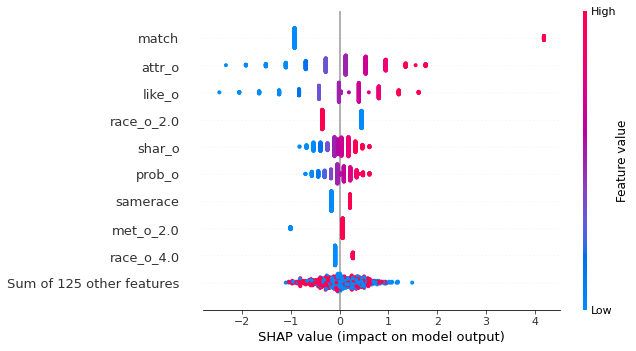

Wall time: 1.17 s


In [113]:
%%time
# refer to 'https://github.com/slundberg/shap/blob/master/notebooks/tabular_examples/linear_models/Sentiment%20Analysis%20with%20Logistic%20Regression.ipynb'
# import shap
import shap
shap.initjs() #%%%%% what is this for?

# Explain the linear model
logreg_explainer1 = shap.Explainer(logreg_best1, X_train_mean_scaled_odmb, feature_names=X_train_mean_scaled_odmb.columns)
logreg_shap_values1 = logreg_explainer1(X_test_mean_scaled_odmb)

# Summarize the effect of all the features
shap.plots.beeswarm(logreg_shap_values1)

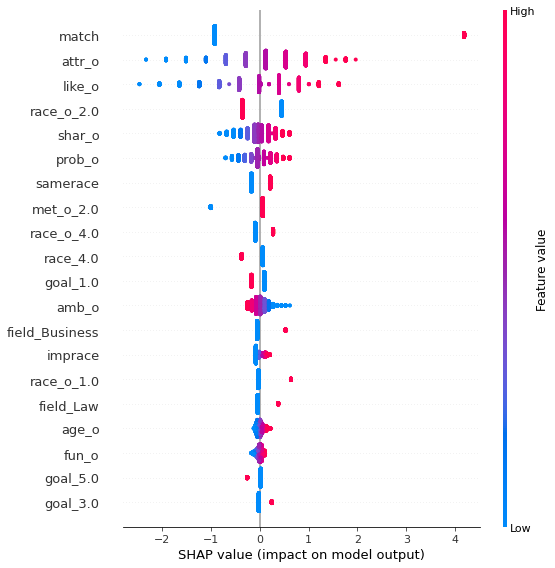

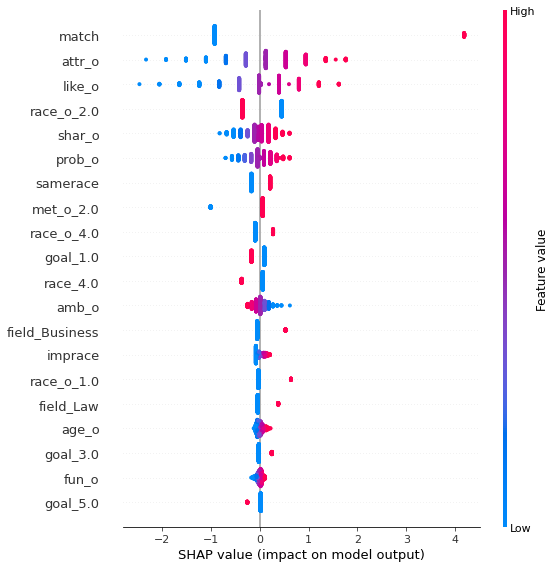

Wall time: 1.72 s


In [114]:
%%time 
# refer to 'https://aigerimshopenova.medium.com/random-forest-classifier-and-shap-how-to-understand-your-customers-and-interpret-a-black-box-model-6166d86820d9'
# Import the package
import shap
shap.initjs()

# SHAP summary plot on training data
logreg_explainer1 = shap.Explainer(logreg_best1, X_train_mean_scaled_odmb, feature_names=X_train_mean_scaled_odmb.columns) # same as above
logreg_shap_values2 = logreg_explainer1.shap_values(X_train_mean_scaled_odmb)
shap.summary_plot(logreg_shap_values2, X_train_mean_scaled_odmb)

# SHAP summary plot on test data
logreg_shap_values3 = logreg_explainer1.shap_values(X_test_mean_scaled_odmb)
shap.summary_plot(logreg_shap_values3, X_test_mean_scaled_odmb)

**shap plot interpretation**
- Feature importance: Variables are ranked in descending order.
- Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
- Correlation: The “high” comes from the red color, and the “positive” impact is shown on the X-axis.

Refererence: 'https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a'

sklearn logistic regression model (rated by female partner): TBD

### 3.6.2 LogisticRegression via statsmodel

In [115]:
# use statsmodels.discrete.discrete_model.LogitResults.get_margeff!?

### 3.6.3 Random Forest via sklearn

#### 3.6.3.1 Using shap

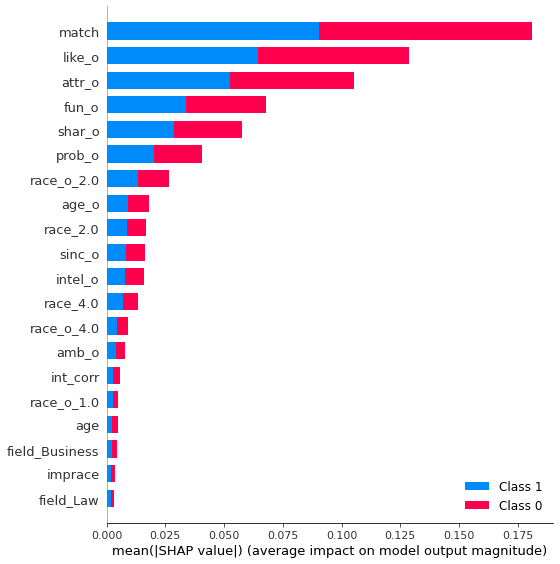

Wall time: 46.7 s


In [116]:
%%time
# refer to 'https://github.com/slundberg/shap/blob/master/notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.ipynb'
import shap

shap.initjs() #%%%%% what is this for?

# Explain the linear model
rfc_explainer1 = shap.TreeExplainer(rfc_best1, feature_names=X_train_mean_scaled_odmb.columns)
rfc_shap_values1 = rfc_explainer1.shap_values(X_train_mean_scaled_odmb) # this shap value is 'list' object with no

# Summarize the effect of all the features
shap.summary_plot(rfc_shap_values1, X_test_mean_scaled_odmb)

In [117]:
# check size of rfc_y_pred1
rfc_y_pred1 # need to convert this to list with 2 element.

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,

In [118]:
# to count the 0 and 1 in y_pred1_rfc
# refer to 'https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray'
import collections
collections.Counter(rfc_y_pred1)

Counter({0: 450, 1: 178})

In [119]:
# ideally this value should be 0 to make symmetry plot above!?
print(np.abs([np.sum(list(rfc_shap_values1[0])), np.sum(list(rfc_shap_values1[1]))] + rfc_explainer1.expected_value - [780, 474]).max()) 
#%%%% original code was rcf_shap_values.sum(1), but rcf_shap_values is list object that does not have sum attribute.
# np.abs(shap_values.sum(1) + explainer.expected_value - pred).max() > this output should be 0 to get symmetry plot.

777.1244959204652


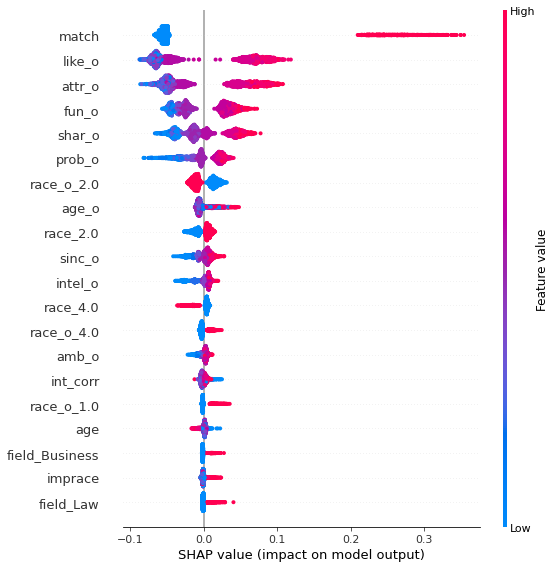

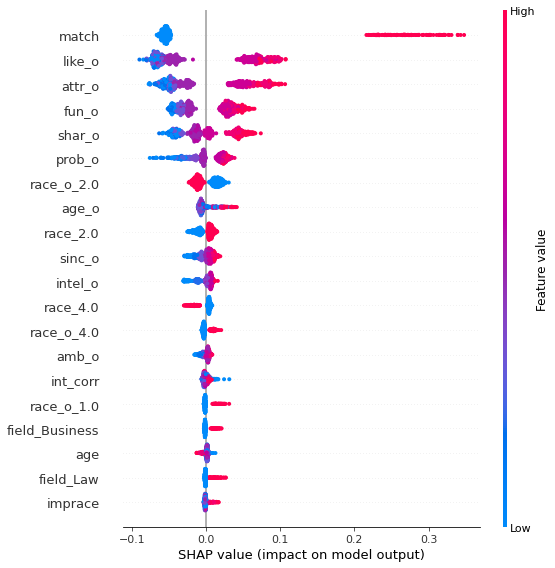

Wall time: 59.4 s


In [120]:
%%time 
# refer to 'https://aigerimshopenova.medium.com/random-forest-classifier-and-shap-how-to-understand-your-customers-and-interpret-a-black-box-model-6166d86820d9'
# Import the package
import shap
shap.initjs()

# SHAP summary plot on training data
#explainer = shap.TreeExplainer(rfc_best1)
rfc_shap_values2 = rfc_explainer1.shap_values(X_train_mean_scaled_odmb, approximate=False, check_additivity=False)
shap.summary_plot(rfc_shap_values2[1], X_train_mean_scaled_odmb)

# SHAP summary plot on test data
#explainer = shap.TreeExplainer(rfc_best1)
rfc_shap_values3 = rfc_explainer1.shap_values(X_test_mean_scaled_odmb, approximate=False, check_additivity=False)
shap.summary_plot(rfc_shap_values3[1], X_test_mean_scaled_odmb)

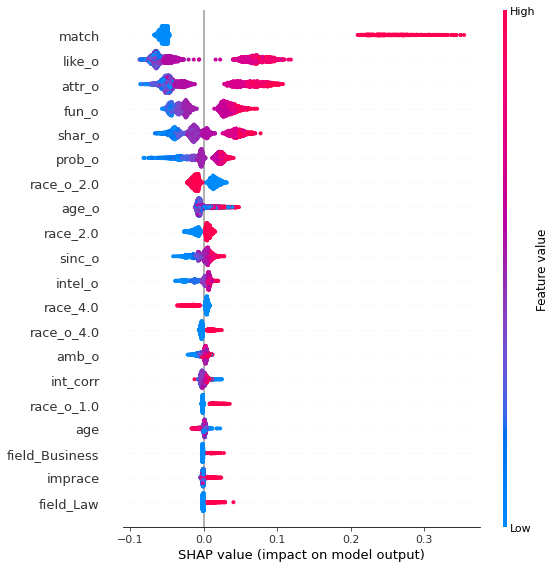

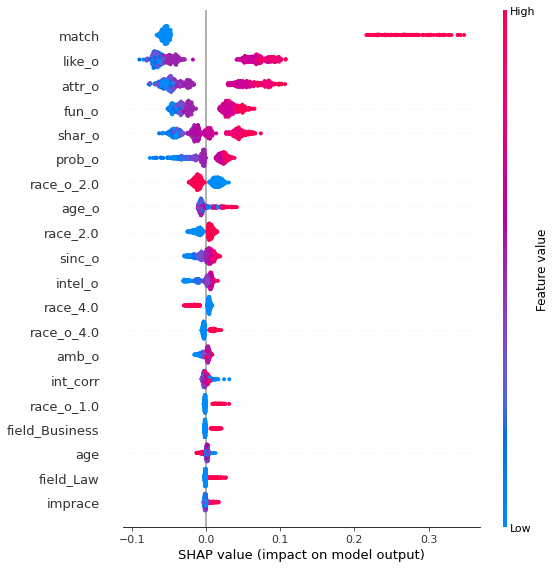

Wall time: 59.2 s


In [121]:
%%time 
# refer to 'https://aigerimshopenova.medium.com/random-forest-classifier-and-shap-how-to-understand-your-customers-and-interpret-a-black-box-model-6166d86820d9'
# Import the package
import shap
shap.initjs()

# SHAP summary plot on training data
#explainer = shap.TreeExplainer(rfc_best1)
rfc_shap_values2a = rfc_explainer1.shap_values(X_train_mean_scaled_odmb)
shap.summary_plot(rfc_shap_values2a[1], X_train_mean_scaled_odmb)

# SHAP summary plot on test data
#explainer = shap.TreeExplainer(rfc_best1)
rfc_shap_values3a = rfc_explainer1.shap_values(X_test_mean_scaled_odmb)
shap.summary_plot(rfc_shap_values3a[1], X_test_mean_scaled_odmb)

#### 3.6.3.2 Using Sklearn Tree model attribute: feature_importances_ 

30


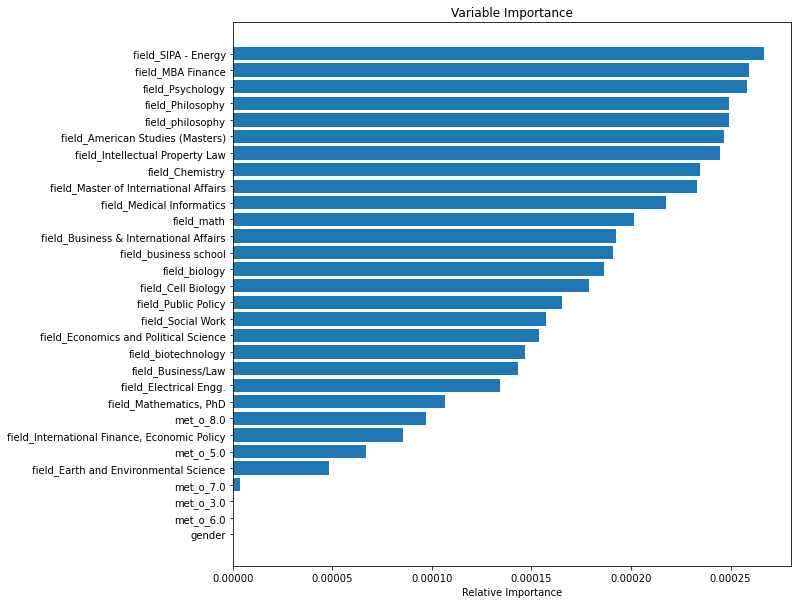

In [122]:
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[:30]
sorted_idx = np.argsort(feature_importance_rfc)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

30


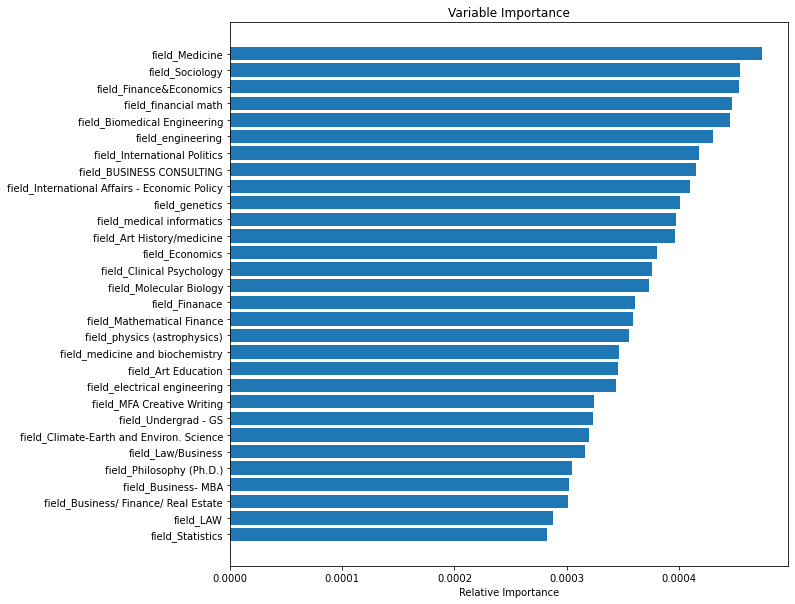

In [123]:
# want to see the importance of attributes...
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[30:60]
sorted_idx = np.argsort(feature_importance_rfc)[30:60]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

30


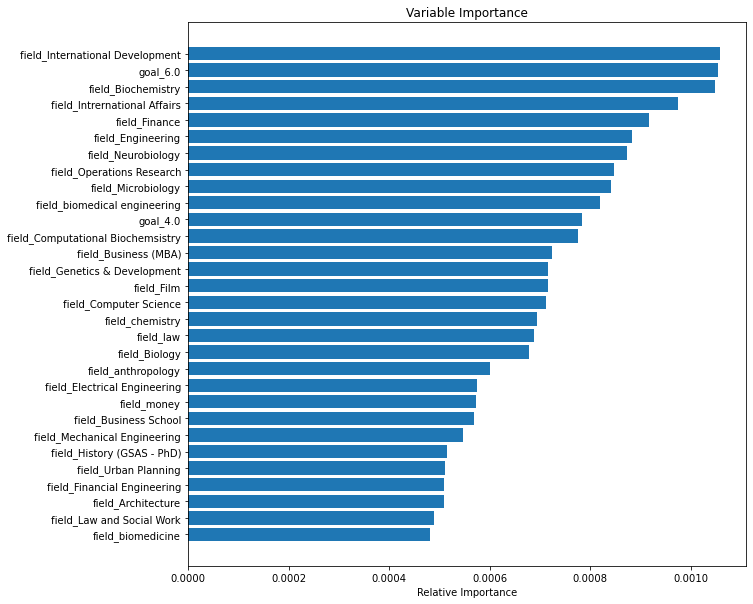

In [124]:
# want to see the importance of attributes...
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[60:90]
sorted_idx = np.argsort(feature_importance_rfc)[60:90]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

30


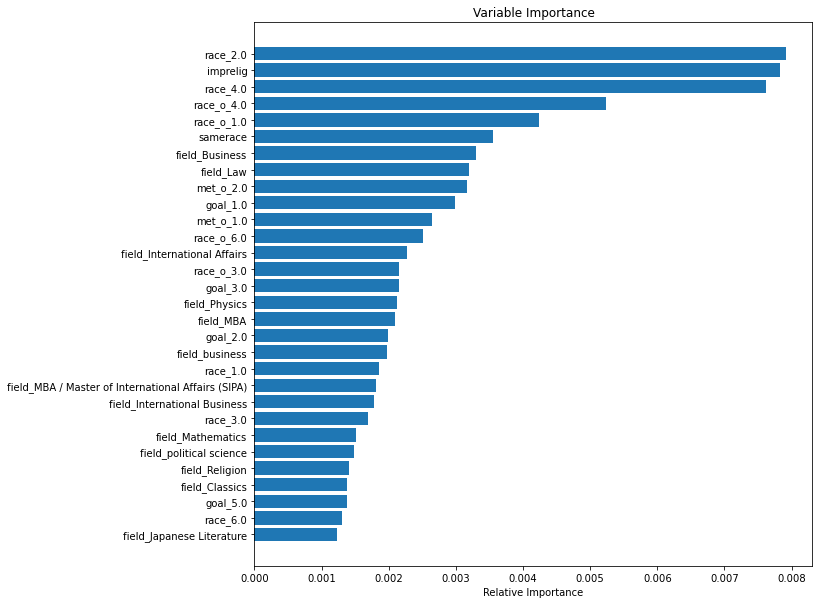

In [125]:
# want to see the importance of attributes...
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[90:120]
sorted_idx = np.argsort(feature_importance_rfc)[90:120]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

14


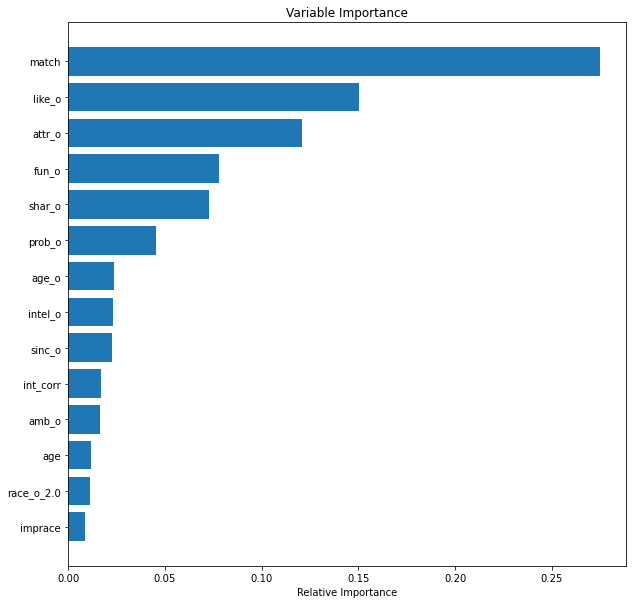

In [126]:
# want to see the importance of attributes...
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[120:150]
sorted_idx = np.argsort(feature_importance_rfc)[120:150]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [130]:
# refer to 'https://ff06-2020.fastforwardlabs.com/'
# to interpret resutls. 

### reference
- sklearn codes:
    - '14.1.2_3_Supervised Learning_Tuning': logisticRegression, confusion_matrix, classification_report, 
    - '14.1.2_4_Supervised Learning with scikit-learn_Preprocessing and Pipeline': buiding pipeline, scaler, get_dummies() 
    - '6_GuidedCapstone/04_preprocessing_and_training_mk': scaler, Random Forest model
     - '14.2.11_Case Study - Logistic Regression/Logistic Regression Advanced Case Study_mk': plot logisticRegression output.
- Statsmodel codes:
    - '11.4.1_Case Study - Linear Regression/Regression Case Study - the Red Wine Dataset - Tier 3_mk': sm.OLS(y, X), plot predictions (y_test vs. y_pred)
- Random Forest model codes:'14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
    - '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
    - '14.3.5_Case Study - Decision Trees - RR Diner Coffee/Decision Tree Specialty Coffee Case Study - Tier 3_mk'
    
- refer to 'https://pandas.pydata.org/pandas-docs/version/0.24.0rc1/api/generated/pandas.Series.to_numpy.html'
    - series to numpy: s.to_numpy()
- data preprocessing: 
    - '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk': get_dummies(), sklearn scaler
    - '14.5.6_Case Study - Gradient Boosting/Gradient Boosting Case Study_mk': exctract categorical data
    - '15.4.3_3_Unsupervised Learning_Dimension reduction': PCA
- feature importance interpretation: SHAP
    - https://aigerimshopenova.medium.com/random-forest-classifier-and-shap-how-to-understand-your-customers-and-interpret-a-black-box-model-6166d86820d9
    - https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
    - https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
    - https://ff06-2020.fastforwardlabs.com/
   

### Questions:
- how do perform cross validation on statsmodel?
    - Answers:
    - currently not avaliable(can't perform cross validation using statsmodels.api yet) and is not compatibible with sklearn cross_val_score or GredSearchCV...etc
    - need to write custom codes if you really want to
    - people usually use sklearn for building ML model.
    - statsmodel is used for quick stats calculation from a model than model optimazation. 
- how to use ElasticNet in sklearn LogisticRegression? (currently only l1 or l2 are available!?)
    - Answers:
    - need to change the default solver (lbfgs) to saga in order to use elasticnet
        - param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 
        - logreg = LogisticRegression(solver='saga', max_iter=10000) 
        - logreg_cv = GridSearchCV(logreg, param_grid, cv=5)
- how to compare the performance of statsmodel and sklearn lotistic model
    - Answers:
    - use sklearn confusion_matrix, classification_report on the y_pred, y_test
    - need to convert the statsmodel's y_pred in probability to binary system (0,1) in advance
    
- how to choose scoring system for GridSearhCV like we can do for cross_val_score? (what is the defaut score?, accuracy?)
    - cv_accuracy = cross_val_score(clf, Xlr, ylr, cv=5, scoring='accuracy')
    - cv_auc = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')
    - Answers:
    - use GridSearhCV(logreg, param_grid, scoring = 'roc_auc', cv=5), default scoring = 'accuracy'
    - should not use 'accuracy' scoring for data with imbalanced disribution.
    - for logistic regression, target variable (0,1), if there is much more (more than 10x!?) 1 than 0 (or vice verso) > imbalanced data
- for logistic regression model, do I need to leave all the binary variable (or only dependent variable) out for scaling.
    - Answers: 
    - leaving it out all the binary viarable for scaling for logistic regression model might be better!?
    - 